# Clasificacion de Perros y Gatos con CNN

Esta es una tarea para la clase de Redes Neuronales con la maestra Edelmira. Entrenaremos una CNN con el fin de usarlo para clasificar perros y gatos usando el celular de nuestra camara.

In [1]:
!pip install tensorflow==2.15.0

In [2]:
!pip install keras==2.15

In [3]:
!pip install tensorflow-datasets

In [4]:
!pip install opencv-python==4.8.1.78

In [5]:
!pip install matplotlib

In [6]:
!pip install scipy

In [7]:
# --- Importacion de librerias ---

import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Sequential
import cv2

2025-11-14 16:01:38.580799: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 16:01:38.583329: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-14 16:01:38.609960: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-14 16:01:38.609989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-14 16:01:38.611082: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Cargando Dataset

In [8]:
#Tensorflow datasets tiene error al descargar el set de perros y gatos y lo solucionaron
#el 16 de mayo pero sigue fallando en los colabs. Entonces se agrega esta linea adicional
#Mas detalle aqui: https://github.com/tensorflow/datasets/issues/3918
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [9]:
datos, metadatos = tfds.load('cats_vs_dogs', as_supervised=True, with_info=True)

In [10]:
TAMANO_IMG=100

# Generamos tuplas (imagen, etiqueta)
datos_entrenamiento = []
for i, (imagen, etiqueta) in enumerate(datos['train']):
    imagen = cv2.resize(imagen.numpy(), (TAMANO_IMG, TAMANO_IMG))
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY) # Escalas de grises
    imagen = imagen.reshape(TAMANO_IMG, TAMANO_IMG, 1) #Cambiar tamano a 100,100,1
    datos_entrenamiento.append([imagen, etiqueta])


In [11]:
#Preparar mis variables X (entradas) y y (etiquetas) separadas

X = [] #imagenes de entrada (pixeles)
y = [] #etiquetas (perro o gato)

for imagen, etiqueta in datos_entrenamiento:
  X.append(imagen)
  y.append(etiqueta)

In [12]:
#Normalizar los datos de las X (imagenes). Se pasan a numero flotante y dividen entre 255 para quedar de 0-1 en lugar de 0-255
X = np.array(X).astype(float) / 255

In [13]:
#Convertir etiquetas en arreglo simple
y = np.array(y)

In [14]:
# Hacemos aumentacion de datos
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range     = 20,
    width_shift_range  = 0.2, # mover la imagen a los lados
    height_shift_range = 0.2,
    shear_range        = 15, # inclinar la imagen
    zoom_range         = [0.8, 1.2],
    horizontal_flip    = True,
    vertical_flip      = False
)

datagen.fit(X)

In [15]:
#Separar los datos de entrenamiento y los datos de pruebas en variables diferentes

len(X) * 0.85 # <-- corresponde a 19,700 imágenes (TRAIN)
len(X) * 0.15 # <-- corresponde a  3,562 imágenes (VALIDATION)

X_entrenamiento = X[:19700]
X_validacion = X[19700:]

y_entrenamiento = y[:19700]
y_validacion = y[19700:]

In [16]:
#Usar la funcion flow del generador para crear un iterador que podamos enviar como entrenamiento a la funcion FIT del modelo
data_gen_entrenamiento = datagen.flow( X_entrenamiento, y_entrenamiento, batch_size=32, shuffle=True  )
data_gen_validacion    = datagen.flow( X_validacion,    y_validacion,    batch_size=32, shuffle=False )

## Modelo

In [17]:
modeloCNN = Sequential([
  Input( shape=(100, 100, 1) ),

  Conv2D( 32, (3,3), activation='relu' ),
  MaxPooling2D( 2, 2 ),
  Conv2D( 64, (3,3), activation='relu' ),
  MaxPooling2D( 2, 2 ),
  Conv2D( 128, (3,3), activation='relu' ),
  MaxPooling2D( 2, 2 ),

  Flatten(),
  Dropout(0.5),
  Dense(100, activation='relu'),
  Dropout(0.5),
  Dense(1, activation='sigmoid')
])

In [18]:
modeloCNN.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [19]:
%time hist_CNN1 = modeloCNN.fit( data_gen_entrenamiento, epochs=50,  batch_size=32, validation_data=data_gen_validacion, verbose=1 )

Epoch 1/50
616/616 [==============================] - 42s 68ms/step - loss: 0.6804 - accuracy: 0.5710 - val_loss: 0.7155 - val_accuracy: 0.5542
Epoch 2/50
616/616 [==============================] - 42s 69ms/step - loss: 0.6432 - accuracy: 0.6330 - val_loss: 0.6344 - val_accuracy: 0.6353
Epoch 3/50
616/616 [==============================] - 42s 68ms/step - loss: 0.6092 - accuracy: 0.6734 - val_loss: 0.5883 - val_accuracy: 0.6903
Epoch 4/50
616/616 [==============================] - 44s 71ms/step - loss: 0.5882 - accuracy: 0.6914 - val_loss: 0.5651 - val_accuracy: 0.7117
Epoch 5/50
616/616 [==============================] - 42s 68ms/step - loss: 0.5687 - accuracy: 0.7096 - val_loss: 0.5452 - val_accuracy: 0.7246
Epoch 6/50
616/616 [==============================] - 43s 70ms/step - loss: 0.5511 - accuracy: 0.7233 - val_loss: 0.5206 - val_accuracy: 0.7485
Epoch 7/50
616/616 [==============================] - 41s 67ms/step - loss: 0.5368 - accuracy: 0.7358 - val_loss: 0.5424 - val_accuracy:

In [22]:
modeloCNN.save("perros_gatos_CNN.h5")

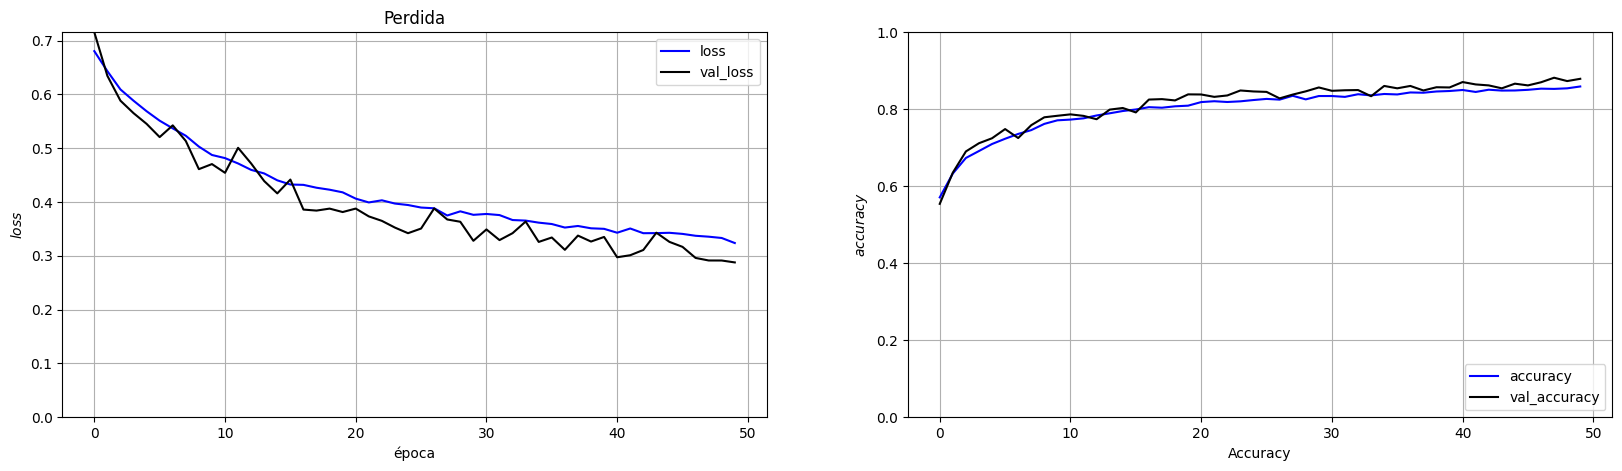

In [21]:
plt.figure( figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(hist_CNN1.epoch, hist_CNN1.history['loss'], 'b',label='loss')
plt.plot(hist_CNN1.epoch, hist_CNN1.history['val_loss'], 'k',label='val_loss')
plt.title(u'Perdida')
plt.xlabel(u'época')
plt.ylabel(r'$loss$')
plt.ylim(0, max(max(hist_CNN1.history['loss']),max(hist_CNN1.history['val_loss'])))
plt.grid()
plt.legend(loc='upper right')


plt.subplot(1,2,2)
plt.plot(hist_CNN1.epoch, hist_CNN1.history['accuracy'], 'b',label='accuracy')
plt.plot(hist_CNN1.epoch, hist_CNN1.history['val_accuracy'], 'k',label='val_accuracy')
#plt.title(u'binary_crossentropy')
plt.xlabel(u'Accuracy')
plt.ylabel(r'$accuracy$')
plt.ylim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.show()